In [ ]:
#---------------------------------------------------------------------------------------------------#
# IMPORTS
#---------------------------------------------------------------------------------------------------#
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import cm
import plotly.io as pio
import plotly.express as px
import plotly.subplots as sp
import math
from pprint import pprint
import pickle
from plotly.subplots import make_subplots
from scipy.stats import mode, pearsonr, norm
from scipy.integrate import cumulative_trapezoid
from scipy.signal import correlate
import gc  # garbage collector for removing large variables from memory instantly 
import importlib  # for force updating changed packages 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Interactive widgets for dropdowns
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except ImportError:
    print("⚠️ ipywidgets not available. Install with: pip install ipywidgets")
    WIDGETS_AVAILABLE = False

%config Completer.use_jedi = False  # Fixes autocomplete issues
%config InlineBackend.figure_format = 'retina'  # Improves plot resolution

# Mean, SEM, and Grand Average Analysis Notebook

This notebook computes mean and SEM per mouse and grand averages across selected animals.

**Usage:**
1. Configure settings in the Configuration section below
2. Select animals to process
3. Choose whether to save pickle and CSV files
4. Run the analysis cells
5. Use interactive dropdowns for plotting

In [ ]:
#---------------------------------------------------------------------------------------------------#
# CONFIGURATION SECTION
#---------------------------------------------------------------------------------------------------#
# Configure all settings here before running the analysis

# Cohort selection
COHORT_OPTIONS = {
    "Cohort1": {
        "mice": ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2721', 'B6J2722', 'B6J2723'],
        "identifier": "Cohort1"
    },
    "Cohort3": {
        "mice": ["B6J2780", "B6J2781", "B6J2783", "B6J2782"],
        "identifier": "Cohort3"
    }
}

# Select cohort
cohort_identifier = "Cohort3"  # Options: "Cohort1" or "Cohort3"

# Select which animals to process (subset of the cohort's available mice)
# Leave empty list [] to process all mice in the cohort
selected_mice = []  # Example: ['B6J2717', 'B6J2718'] or [] for all

# Event name for CSV file loading
event_name = '_Apply halt_2s_baselined_data.csv'  # Options: '_Apply halt_2s_baselined_data.csv', '_No halt_right_turns_baselined_data.csv', '_No halt_left_turns_baselined_data.csv'

# Data columns to analyze
selected_columns = [
    'Velocity_0X_Baseline', 'Motor_Velocity_Baseline', 
    'z_470_Baseline', 'z_560_Baseline',
    'Velocity_0X', 'Motor_Velocity', 'z_470', 'z_560'
]

# Columns to plot
columns_to_plot = [
    'Velocity_0X_Baseline', 'Motor_Velocity_Baseline', 
    'z_470_Baseline', 'z_560_Baseline'
]

# Save options
SAVE_PICKLE = True  # Save results as pickle file
SAVE_CSV = True      # Save grand averages with SEM as CSV file
GENERATE_PLOTS = True  # Generate plots

# Data directories (add your paths here)
DATA_DIRS = [
    Path('/Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4').expanduser(),
    # Path('/Volumes/RanczLab2/20241125_Cohort1_rotation/Visual_mismatch_day4').expanduser(),
    # Path('/Volumes/RanczLab2/20250409_Cohort3_rotation/Vestibular_mismatch_day1').expanduser(),
    # Add more directories as needed
]

#---------------------------------------------------------------------------------------------------#
# Auto-configure based on cohort selection
#---------------------------------------------------------------------------------------------------#
if cohort_identifier in COHORT_OPTIONS:
    cohort_info = COHORT_OPTIONS[cohort_identifier]
    available_mice = cohort_info["mice"]
    if not selected_mice:  # If empty, use all mice
        selected_mice = available_mice
    else:  # Filter to only include valid mice
        selected_mice = [m for m in selected_mice if m in available_mice]
    print(f"✅ Cohort: {cohort_identifier}")
    print(f"✅ Available mice: {available_mice}")
    print(f"✅ Selected mice: {selected_mice}")
else:
    raise ValueError(f"Invalid cohort_identifier: {cohort_identifier}. Must be one of {list(COHORT_OPTIONS.keys())}")

In [ ]:
#---------------------------------------------------------------------------------------------------#
# DATA LOADING
#---------------------------------------------------------------------------------------------------#
def load_aligned_data(data_dirs, event_name, selected_mice):
    """
    Load aligned data from CSV files for selected mice.
    
    Parameters:
    -----------
    data_dirs : list
        List of data directory paths
    event_name : str
        Event name suffix for CSV files
    selected_mice : list
        List of mouse names to load
    
    Returns:
    --------
    loaded_data : dict
        Dictionary with data paths as keys and mouse data as values
    """
    # Collect raw data paths (excluding '_processedData' dirs)
    rawdata_paths = []
    for data_dir in data_dirs:
        if not Path(data_dir).exists():
            print(f"⚠️ Directory does not exist: {data_dir}")
            continue
        subdirs = [p for p in Path(data_dir).iterdir() if p.is_dir() and not p.name.endswith('_processedData')]
        rawdata_paths.extend(subdirs)
    
    if not rawdata_paths:
        print("⚠️ No raw data paths found!")
        return {}
    
    # Build processed data paths
    data_paths = [raw.parent / f"{raw.name}_processedData/aligned_data" for raw in rawdata_paths]
    mouse_names = [raw.name.split('-')[0] for raw in rawdata_paths]
    
    # Load data
    loaded_data = {}
    for idx, data_path in enumerate(data_paths, start=1):
        mouse_name = mouse_names[idx - 1]
        
        # Skip if mouse not in selected list
        if selected_mice and mouse_name not in selected_mice:
            print(f"⏭️  Skipping {mouse_name} (not in selected_mice)")
            continue
        
        if mouse_name == 'baselined':
            print(f"⚠️ Skipping directory {data_path} as it does not contain a valid mouse name.")
            continue
        
        csv_file_path = data_path / f"{mouse_name}{event_name}"
        
        try:
            aligned_df = pd.read_csv(csv_file_path)
            print(f"✅ [{idx}/{len(data_paths)}] Loaded {mouse_name} from {csv_file_path}")
            
            loaded_data[data_path] = {
                'mouse_name': mouse_name,
                'data_path': data_path
            }
            
            # Add each column as a separate key
            for column in aligned_df.columns:
                loaded_data[data_path][column] = aligned_df[column].values
            
            print(f"   Data: {len(aligned_df)} rows, {len(aligned_df.columns)} columns")
            del aligned_df
            gc.collect()
            
        except FileNotFoundError:
            print(f"⚠️ File not found: {csv_file_path}, skipping...")
            continue
    
    print(f"\n📊 Loaded data for {len(loaded_data)} mice")
    return loaded_data

# Load the data
loaded_data = load_aligned_data(DATA_DIRS, event_name, selected_mice)

In [ ]:
#---------------------------------------------------------------------------------------------------#
# ANALYSIS FUNCTIONS
#---------------------------------------------------------------------------------------------------#

def compute_mouse_means_and_grand_average(loaded_data, selected_columns, main_data_dir, selected_mice):
    """
    Compute means per mouse and grand averages across selected mice for selected columns.
    
    Parameters:
    loaded_data (dict): Dictionary with data paths as keys and mouse data as values
    selected_columns (list): List of column names to analyze
    main_data_dir (str/Path): Main directory to save results
    selected_mice (list): List of mouse names to include in the grand average
    
    Returns:
    tuple: (mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems)
    """
    
    main_data_dir = Path(main_data_dir)
    
    print(f"Processing selected columns: {selected_columns}")
    
    # Step 1: Compute mean and SEM for each mouse
    mean_data_per_mouse = {}
    sem_data_per_mouse = {}
    
    for data_path, data in loaded_data.items():
        mouse_name = data['mouse_name']
        if mouse_name not in selected_mice:
            print(f"Skipping mouse {mouse_name} as it is not in the selected mice list.")
            continue
        
        print(f"Processing mouse: {mouse_name}")
        
        # Create DataFrame from the loaded data
        df = pd.DataFrame(data)
        
        # Check which selected columns are available
        available_columns = [col for col in selected_columns if col in df.columns]
        missing_columns = [col for col in selected_columns if col not in df.columns]
        
        if missing_columns:
            print(f"⚠️  Missing columns for {mouse_name}: {missing_columns}")
        
        if 'Time (s)' not in df.columns:
            print(f"⚠️  'Time (s)' column not found for {mouse_name}, skipping...")
            continue
        
        # Group by time and compute mean and SEM
        grouped = df.groupby('Time (s)')
        
        # Only use numeric columns that are in our selected list
        numeric_selected = []
        for col in available_columns:
            if col != 'Time (s)' and pd.api.types.is_numeric_dtype(df[col]):
                numeric_selected.append(col)
        
        if len(numeric_selected) == 0:
            print(f"⚠️  No numeric columns found for {mouse_name}")
            continue
        
        mean_data_per_mouse[mouse_name] = grouped[numeric_selected].mean()
        sem_data_per_mouse[mouse_name] = grouped[numeric_selected].sem()
        
        print(f"✅ Processed {len(numeric_selected)} columns for {mouse_name}")
    
    # Step 2: Compute grand averages across selected mice
    print(f"\n📊 Computing grand averages across {len(mean_data_per_mouse)} selected mice...")
    
    # Get all unique time points
    all_time_points = set()
    for mouse_data in mean_data_per_mouse.values():
        all_time_points.update(mouse_data.index)
    all_time_points = sorted(list(all_time_points))
    
    # Get all columns that were successfully processed
    all_processed_columns = set()
    for mouse_data in mean_data_per_mouse.values():
        all_processed_columns.update(mouse_data.columns)
    all_processed_columns = sorted(list(all_processed_columns))
    
    print(f"Time points: {len(all_time_points)} from {min(all_time_points):.2f}s to {max(all_time_points):.2f}s")
    print(f"Processed columns: {all_processed_columns}")
    
    # Create grand average DataFrame
    grand_averages = pd.DataFrame(index=all_time_points, columns=all_processed_columns)
    grand_averages.index.name = 'Time (s)'
    
    grand_sems = pd.DataFrame(index=all_time_points, columns=all_processed_columns)
    grand_sems.index.name = 'Time (s)'
    
    # Compute grand averages for each column and time point
    for col in all_processed_columns:
        for time_point in all_time_points:
            # Collect data from all selected mice for this time point and column
            mouse_values = []
            for mouse_name, mouse_data in mean_data_per_mouse.items():
                if time_point in mouse_data.index and col in mouse_data.columns:
                    value = mouse_data.loc[time_point, col]
                    if not pd.isna(value):
                        mouse_values.append(value)
            
            if len(mouse_values) > 0:
                grand_averages.loc[time_point, col] = np.mean(mouse_values)
                if len(mouse_values) > 1:
                    grand_sems.loc[time_point, col] = np.std(mouse_values) / np.sqrt(len(mouse_values))
                else:
                    grand_sems.loc[time_point, col] = 0
    
    return mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems

def analyze_mice_data(loaded_data, selected_columns, main_data_dir):
    """
    Complete analysis workflow: compute means, grand averages, save CSV, and create plots.
    
    Parameters:
    loaded_data (dict): Your loaded_data dictionary
    selected_columns (list): List of column names to analyze (including 'Time (s)')
    main_data_dir (str/Path): Main directory to save results
    
    Returns:
    dict: Complete results including individual and grand averages
    """
    
    print(f"\n{'='*60}")
    print(f"MOUSE DATA ANALYSIS")
    print(f"{'='*60}")
    
    selected_mice= selected_mice1 if cohort_identifier == "Cohort1" else selected_mice2
    # Compute means and grand averages
    mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems = compute_mouse_means_and_grand_average(
        loaded_data, selected_columns, main_data_dir, selected_mice
    )

    # Print summary
    print(f"\n📊 ANALYSIS COMPLETE:")
    print(f"   • Number of mice analyzed: {len(mean_data_per_mouse)}")
    print(f"   • Mouse names: {list(mean_data_per_mouse.keys())}")
    print(f"   • Columns processed: {list(grand_averages.columns)}")
    print(f"   • Time range: {grand_averages.index.min():.2f}s to {grand_averages.index.max():.2f}s")
    print(f"   • Files saved in: {main_data_dir}")
    
    # Return all results
    results = {
        'mean_data_per_mouse': mean_data_per_mouse,
        'sem_data_per_mouse': sem_data_per_mouse,
        'grand_averages': grand_averages,
        'grand_sems': grand_sems,
    }
    
    return results

In [ ]:
#---------------------------------------------------------------------------------------------------#
# RUN ANALYSIS
#---------------------------------------------------------------------------------------------------#

def save_results(results, filename='results.pkl'):
    """Save results to a pickle file."""
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"✅ Results saved to {filename}")

# Determine main data directory
main_data_dir = DATA_DIRS[0] if DATA_DIRS else Path.cwd()

# Run analysis
if loaded_data:
    results = analyze_mice_data(loaded_data, selected_columns, main_data_dir)
else:
    print("⚠️ No data loaded. Please check your configuration and data paths.")
    results = None

In [ ]:
#---------------------------------------------------------------------------------------------------#
# SAVE RESULTS
#---------------------------------------------------------------------------------------------------#

if results and SAVE_PICKLE:
    # Generate unique filename
    vmm_event_name = main_data_dir.name
    pickle_filename = f"{cohort_identifier}_{vmm_event_name}{event_name.replace('.csv', '')}.pkl"
    save_results(results, pickle_filename)
else:
    print("⏭️  Skipping pickle save (SAVE_PICKLE=False or no results)")

In [ ]:
#---------------------------------------------------------------------------------------------------#
# PLOTTING FUNCTIONS
#---------------------------------------------------------------------------------------------------#

def plot_time_series_and_scatter(results, columns_to_plot, selected_mice, main_data_dir, event_name):
    """
    Plot time series and scatter plots for each column.
    """
    # Plot properties
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    # Generate color palette
    color_palette = plt.cm.Set2.colors
    mouse_colors = {mouse: color_palette[i % len(color_palette)] for i, mouse in enumerate(selected_mice)}
    
    for column_to_plot in columns_to_plot:
        if column_to_plot not in results['grand_averages'].columns:
            print(f"⚠️ Column {column_to_plot} not found in results, skipping...")
            continue
        
        print(f"\n📊 Plotting: {column_to_plot}")
        
        # Time series plot
        plt.figure(figsize=(8, 4))
        mice_plotted = []
        
        for mouse in selected_mice:
            if mouse in results['mean_data_per_mouse']:
                mice_plotted.append(mouse)
                mean_data = results['mean_data_per_mouse'][mouse][column_to_plot]
                sem_data = results['sem_data_per_mouse'][mouse][column_to_plot]
                
                mean_data = pd.to_numeric(mean_data, errors='coerce')
                sem_data = pd.to_numeric(sem_data, errors='coerce')
                time_points = pd.to_numeric(mean_data.index, errors='coerce')
                
                valid_mask = ~(pd.isna(mean_data) | pd.isna(sem_data) | pd.isna(time_points))
                mean_data_clean = mean_data[valid_mask]
                sem_data_clean = sem_data[valid_mask]
                time_points_clean = time_points[valid_mask]
                
                plt.plot(time_points_clean, mean_data_clean, label=f'{mouse} Mean', color=mouse_colors[mouse])
                plt.fill_between(time_points_clean, mean_data_clean - sem_data_clean, 
                                mean_data_clean + sem_data_clean, color=mouse_colors[mouse], alpha=0.2)
        
        # Grand average
        grand_mean = results['grand_averages'][column_to_plot]
        grand_sem = results['grand_sems'][column_to_plot]
        grand_mean = pd.to_numeric(grand_mean, errors='coerce')
        grand_sem = pd.to_numeric(grand_sem, errors='coerce')
        time_points = pd.to_numeric(grand_mean.index, errors='coerce')
        
        valid_mask = ~(pd.isna(grand_mean) | pd.isna(grand_sem) | pd.isna(time_points))
        grand_mean_clean = grand_mean[valid_mask]
        grand_sem_clean = grand_sem[valid_mask]
        time_points_clean = time_points[valid_mask]
        
        plt.plot(time_points_clean, grand_mean_clean, label='Grand Average', color='black', linewidth=2)
        plt.fill_between(time_points_clean, grand_mean_clean - grand_sem_clean, 
                        grand_mean_clean + grand_sem_clean, color='gray', alpha=0.3)
        
        plt.xlabel('Time (s)')
        plt.ylabel(column_to_plot)
        plt.title(f'Mean and SEM of {column_to_plot} Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        # Save plot
        try:
            baselined_dir = main_data_dir / "baselined"
            baselined_dir.mkdir(exist_ok=True)
            plot_filename = baselined_dir / f"{column_to_plot}{event_name.replace('.csv', '')}.pdf"
            plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
            print(f"   ✅ Saved: {plot_filename}")
        except Exception as e:
            print(f"   ⚠️ Error saving plot: {e}")
        
        plt.show()
        
        # Scatter plot
        pre_time = (-2, 0)
        post_time = (0, 2)
        
        pre_values, post_values, mouse_labels = [], [], []
        
        for mouse in selected_mice:
            if mouse in results['mean_data_per_mouse']:
                mean_data = results['mean_data_per_mouse'][mouse][column_to_plot]
                pre_mean = mean_data.loc[(mean_data.index >= pre_time[0]) & (mean_data.index < pre_time[1])].mean()
                post_mean = mean_data.loc[(mean_data.index >= post_time[0]) & (mean_data.index <= post_time[1])].mean()
                pre_values.append(pre_mean)
                post_values.append(post_mean)
                mouse_labels.append(mouse)
        
        grand_mean = results['grand_averages'][column_to_plot]
        pre_grand_mean = grand_mean.loc[(grand_mean.index >= pre_time[0]) & (grand_mean.index < pre_time[1])].mean()
        post_grand_mean = grand_mean.loc[(grand_mean.index >= post_time[0]) & (grand_mean.index <= post_time[1])].mean()
        
        grand_sem = results['grand_sems'][column_to_plot]
        pre_grand_sem = grand_sem.loc[(grand_sem.index >= pre_time[0]) & (grand_sem.index < pre_time[1])].mean()
        post_grand_sem = grand_sem.loc[(grand_sem.index >= post_time[0]) & (grand_sem.index <= post_time[1])].mean()
        
        plt.figure(figsize=(3, 4))
        
        for i, mouse in enumerate(mouse_labels):
            plt.plot([1, 2], [pre_values[i], post_values[i]], color=mouse_colors[mouse], 
                    marker='o', linewidth=1, label=mouse)
        
        plt.plot([1, 2], [pre_grand_mean, post_grand_mean], color='black', marker='o', 
                markersize=8, linewidth=1, label='Grand Avg')
        plt.errorbar([1, 2], [pre_grand_mean, post_grand_mean], 
                    yerr=[pre_grand_sem, post_grand_sem], fmt='o', color='black', capsize=5)
        
        plt.xticks([1, 2], [pre_time, post_time])
        plt.title(f'Mean {column_to_plot} Before and After Time 0')
        plt.ylabel(column_to_plot)
        plt.xlim(0.8, 2.2)
        plt.grid(True)
        
        if column_to_plot == 'Velocity_0X_Baseline':
            plt.ylim(-0.01, 0.08)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        unique_labels = {}
        for h, l in zip(handles, labels):
            if l not in unique_labels:
                unique_labels[l] = h
        plt.legend(unique_labels.values(), unique_labels.keys(), loc='best', fontsize='small')
        plt.tight_layout()
        
        try:
            plot_filename = baselined_dir / f"{column_to_plot}{event_name.replace('.csv', '')}_scatterplot.pdf"
            plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
            print(f"   ✅ Saved scatter: {plot_filename}")
        except Exception as e:
            print(f"   ⚠️ Error saving scatter plot: {e}")
        
        plt.show()
        plt.clf()
        plt.close()

In [ ]:
#---------------------------------------------------------------------------------------------------#
# GENERATE PLOTS
#---------------------------------------------------------------------------------------------------#

if results and GENERATE_PLOTS:
    print(f"📊 Generating plots for {len(columns_to_plot)} columns...")
    print(f"📊 Selected mice: {selected_mice}")
    print(f"📊 Available mice in results: {list(results['mean_data_per_mouse'].keys())}")
    
    missing_mice = [mouse for mouse in selected_mice if mouse not in results['mean_data_per_mouse']]
    if missing_mice:
        print(f"⚠️ WARNING: These mice are in selected_mice but not in results: {missing_mice}")
    
    plot_time_series_and_scatter(results, columns_to_plot, selected_mice, main_data_dir, event_name)
else:
    print("⏭️  Skipping plot generation (GENERATE_PLOTS=False or no results)")

In [ ]:
#---------------------------------------------------------------------------------------------------#
# SAVE GRAND AVERAGES CSV
#---------------------------------------------------------------------------------------------------#

if results and SAVE_CSV:
    # Create a DataFrame combining grand averages and SEMs
    grand_avg_with_sem = results['grand_averages'].copy()
    for col in results['grand_sems'].columns:
        grand_avg_with_sem[f'{col}_SEM'] = results['grand_sems'][col]
    
    # Generate filename
    csv_filename = main_data_dir / f"grand_averages_with_sem{event_name.replace('.csv', '')}.csv"
    
    # Save the DataFrame to a CSV file
    grand_avg_with_sem.to_csv(csv_filename)
    print(f"✅ Grand averages with SEM saved to: {csv_filename}")
else:
    print("⏭️  Skipping CSV save (SAVE_CSV=False or no results)")

In [ ]:
#---------------------------------------------------------------------------------------------------#
# CORRELATION ANALYSIS (OPTIONAL)
#---------------------------------------------------------------------------------------------------#
# This section is for loading previously saved results and performing correlation analysis

def load_results(filename):
    """Load results from a pickle file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Uncomment and modify paths as needed for correlation analysis
# results_cohort1 = load_results('/Users/nora/Documents/GitHub/vestibular_vr_pipeline/picklefiles/Cohort1_Visual_mismatch_day4_Apply halt_2s_baselined_data.pkl')
# results_cohort2 = load_results('/Users/nora/Documents/GitHub/vestibular_vr_pipeline/picklefiles/Cohort3_Visual_mismatch_day4_Apply halt_2s_baselined_data.pkl')
# time_window = (0, 2)


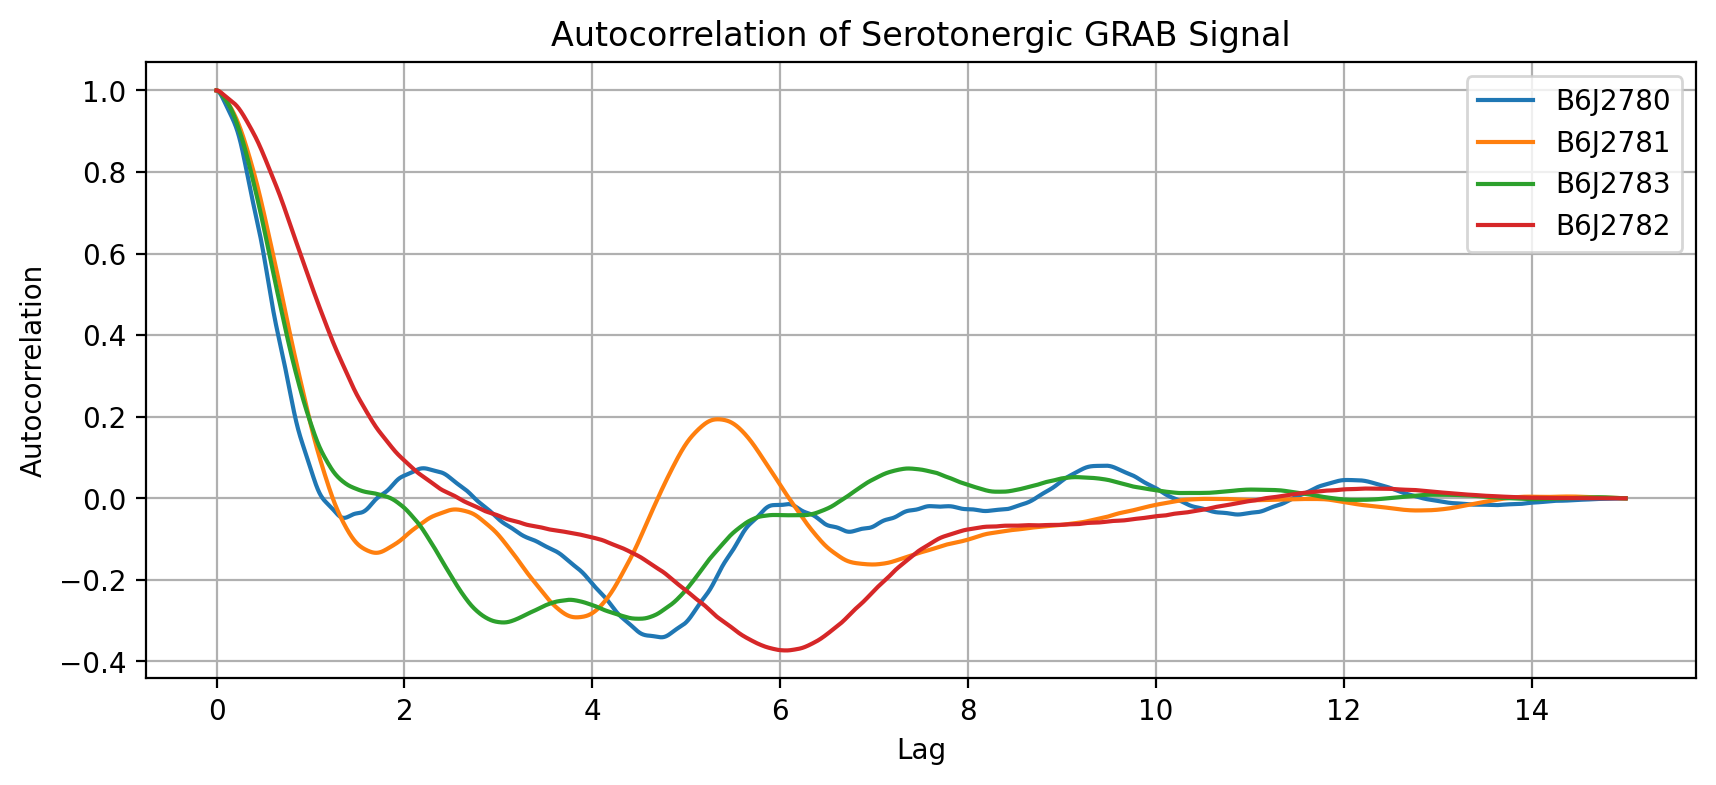

In [37]:
# signal = mean_z_470 = results_cohort1['mean_data_per_mouse']['B6J2719']['z_470']
# signal = mean_z_470 = results_cohort2['mean_data_per_mouse']['B6J2783']['z_470']

def autocorrelate(signal):
    """
    Computes the autocorrelation of a 1D time series.
    
    Parameters:
        signal (np.ndarray): Input time series (1D array)
        
    Returns:
        lags (np.ndarray): Array of lag indices
        autocorr (np.ndarray): Autocorrelation values
    """
    # # Filter signal within the specified time window
    # t0, t1 = time_window
    # signal = signal.loc[(signal.index >= t0) & (signal.index <= t1)]

    # Compute autocorrelation
    all_autocorr_results = {}
    for mouse in selected_mice2:
        if mouse in results_cohort2['mean_data_per_mouse']:
            signal = results_cohort2['mean_data_per_mouse'][mouse]['z_470']
            signal = signal - np.mean(signal)  # remove mean
            result = np.correlate(signal, signal, mode='full')
            autocorr = result[result.size // 2:]  # second half
            autocorr /= autocorr[0]  # normalize
            
            # Use "Time (s)" as x-axis for lag
            time_step = signal.index[1] - signal.index[0]  # Calculate time step from the index
            lags = np.arange(0, autocorr.size) * time_step  # Convert lag indices to seconds
            
            all_autocorr_results[mouse] = (lags, autocorr)
    return all_autocorr_results

# Example usage with synthetic GRAB-like signal
if __name__ == "__main__":
    # Compute autocorrelation for all selected mice in cohort 1
    autocorr_results = autocorrelate(selected_mice2)

    # Plot the results for each mouse
    plt.figure(figsize=(10, 4))
    for mouse, (lags, autocorr) in autocorr_results.items():
        plt.plot(lags, autocorr, label=f"{mouse}")
    
    plt.title("Autocorrelation of Serotonergic GRAB Signal")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#compute correlations between Velocity_0X and z_470, z_560 for each cohort
def fisher_z(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def compare_correlations(r1, n1, r2, n2):
    z1 = fisher_z(r1)
    z2 = fisher_z(r2)
    se = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))
    z = (z1 - z2) / se
    p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

# def extract_means(results, mice, time_window, columns=('Velocity_0X_Baseline', 'z_470_Baseline', 'z_560_Baseline')):
def extract_means(results, mice, time_window, columns=columns_to_plot):
    """
    Extract mean values for specified columns within a given time window for a list of mice.

    Parameters:
    results (dict): Dictionary containing data for each mouse.
    mice (list): List of mouse names to extract data for.
    time_wi
    ndow (tuple): Time window (start, end) for extracting mean values.
    columns (list): List of column names to extract.

    Returns:
    tuple: Mean values for Velocity_0X, z_470, z_560, and valid mouse names.
    """
    v_means, z470_means, z560_means, valid_mice = [], [], [], []
    t0, t1 = time_window

    for mouse in mice:
        if mouse not in results['mean_data_per_mouse']:
            continue
        df = results['mean_data_per_mouse'][mouse]
        if not all(col in df.columns for col in columns):
            continue

        df_window = df.loc[(df.index >= t0) & (df.index <= t1)]
        v = df_window[columns[0]].mean()
        z470 = df_window[columns[1]].mean()
        z560 = df_window[columns[2]].mean()

        if not any(pd.isnull([v, z470, z560])):
            v_means.append(v)
            z470_means.append(z470)
            z560_means.append(z560)
            valid_mice.append(mouse)

    return v_means, z470_means, z560_means, valid_mice

In [ ]:
# EXTRACT MEANS FOR EACH COHORT

time_window = time_window  # Define the time window
v1, z470_1, z560_1, ids1 = extract_means(results_cohort1, selected_mice1, time_window)
v2, z470_2, z560_2, ids2 = extract_means(results_cohort2, selected_mice2, time_window)

# Move velocity and z_470 of B6J2782 from cohort2 to cohort1
target_mouse = "B6J2782"  # Specify the mouse to move
exclude_mice = ["B6J2722"]  # List of mice to exclude

# Exclude mice from both cohorts
ids1 = [mouse for mouse in ids1 if mouse not in exclude_mice]
ids2 = [mouse for mouse in ids2 if mouse not in exclude_mice]

if target_mouse in ids2:
    idx = ids2.index(target_mouse)

    # --- MOVE velocity and z_470 to Cohort 1 ---
    v1.append(v2[idx])
    z470_1.append(z470_2[idx])
    # Add placeholder to z560_1 to keep list lengths equal
    z560_1.append(np.nan)  
    ids1.append(target_mouse + " (from Cohort 2)")

    # --- KEEP velocity and z_560 in Cohort 2 ---
    v2.append(v2[idx])          # duplicate velocity for z_560 correlation
    z560_2.append(z560_2[idx])
    z470_2.append(np.nan)       # add placeholder to z470_2 to keep lengths equal
    ids2.append(target_mouse + " (z_560)")

    # --- REMOVE original entry from Cohort 2 ---
    del v2[idx]
    del z470_2[idx]
    del z560_2[idx]
    del ids2[idx]

    print(f"✅ Moved velocity & z_470 of {target_mouse} to Cohort 1.")
    print(f"✅ Retained velocity & z_560 of {target_mouse} in Cohort 2.")
else:
    print(f"⚠️ Mouse {target_mouse} not found in Cohort 2.")

In [ ]:
#compute correlations for both cohorts
#--------    
# PLOT properties
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

def move_mouse_data_fixed(v1, z470_1, z560_1, ids1, v2, z470_2, z560_2, ids2, 
                         target_mouse=target_mouse, exclude_mice=exclude_mice):
    """
    Fixed version that maintains array consistency
    """
    # Convert to lists if not already (for easier manipulation)
    v1, z470_1, z560_1, ids1 = list(v1), list(z470_1), list(z560_1), list(ids1)
    v2, z470_2, z560_2, ids2 = list(v2), list(z470_2), list(z560_2), list(ids2)
    
    # Exclude mice from both cohorts
    for mouse in exclude_mice:
        # Remove from cohort 1
        while mouse in ids1:
            idx = ids1.index(mouse)
            del v1[idx], z470_1[idx], z560_1[idx], ids1[idx]
        
        # Remove from cohort 2
        while mouse in ids2:
            idx = ids2.index(mouse)
            del v2[idx], z470_2[idx], z560_2[idx], ids2[idx]
    
    # Move target mouse data
    if target_mouse in ids2:
        idx = ids2.index(target_mouse)
        
        # Store the data to move
        target_v = v2[idx]
        target_z470 = z470_2[idx]
        target_z560 = z560_2[idx]
        
        # Remove original entry from Cohort 2
        del v2[idx], z470_2[idx], z560_2[idx], ids2[idx]
        
        # Add to Cohort 1 (velocity and z_470, NaN for z_560)
        v1.append(target_v)
        z470_1.append(target_z470)
        z560_1.append(np.nan)
        ids1.append(target_mouse + " (from Cohort 2)")
        
        # Keep z_560 correlation in Cohort 2 (velocity and z_560, NaN for z_470)
        v2.append(target_v)
        z470_2.append(np.nan)
        z560_2.append(target_z560)
        ids2.append(target_mouse + " (z_560)")
        
        print(f"✅ Moved velocity & z_470 of {target_mouse} to Cohort 1.")
        print(f"✅ Retained velocity & z_560 of {target_mouse} in Cohort 2.")
    else:
        print(f"⚠️ Mouse {target_mouse} not found in Cohort 2.")
    
    return v1, z470_1, z560_1, ids1, v2, z470_2, z560_2, ids2

def analyze_correlations_from_data_fixed(
    v1, z470_1, z560_1, ids1,
    v2, z470_2, z560_2, ids2,
    time_window=None,
    plot=True
):
    """
    Fixed correlation analysis function
    """
    def fisher_z(r):
        return 0.5 * np.log((1 + r) / (1 - r))

    def compare_correlations(r1, n1, r2, n2):
        z1 = fisher_z(r1)
        z2 = fisher_z(r2)
        se = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))
        z = (z1 - z2) / se
        p = 2 * (1 - norm.cdf(abs(z)))
        return z, p

    def filter_valid_pairs(x, y, labels):
        x = np.array(x)
        y = np.array(y)
        labels = np.array(labels)
        
        # Ensure all arrays have the same length
        min_len = min(len(x), len(y), len(labels))
        x = x[:min_len]
        y = y[:min_len]
        labels = labels[:min_len]
        
        # Filter out NaN values
        mask = ~np.isnan(x) & ~np.isnan(y)
        return x[mask], y[mask], labels[mask]

    if time_window is None:
        time_window = (0, 2)  # Default time window if not specified

    # Filter valid pairs for each correlation
    v1_470, z470_1_filt, ids1_470 = filter_valid_pairs(v1, z470_1, ids1)
    v1_560, z560_1_filt, ids1_560 = filter_valid_pairs(v1, z560_1, ids1)
    v2_470, z470_2_filt, ids2_470 = filter_valid_pairs(v2, z470_2, ids2)
    v2_560, z560_2_filt, ids2_560 = filter_valid_pairs(v2, z560_2, ids2)

    # Calculate correlations
    results = {}
    if len(v1_470) > 1:
        corr1_470, p1_470 = pearsonr(v1_470, z470_1_filt)
        results['corr1_470'] = (corr1_470, p1_470, len(v1_470))
    else:
        results['corr1_470'] = (np.nan, np.nan, len(v1_470))
        
    if len(v1_560) > 1:
        corr1_560, p1_560 = pearsonr(v1_560, z560_1_filt)
        results['corr1_560'] = (corr1_560, p1_560, len(v1_560))
    else:
        results['corr1_560'] = (np.nan, np.nan, len(v1_560))
        
    if len(v2_470) > 1:
        corr2_470, p2_470 = pearsonr(v2_470, z470_2_filt)
        results['corr2_470'] = (corr2_470, p2_470, len(v2_470))
    else:
        results['corr2_470'] = (np.nan, np.nan, len(v2_470))
        
    if len(v2_560) > 1:
        corr2_560, p2_560 = pearsonr(v2_560, z560_2_filt)
        results['corr2_560'] = (corr2_560, p2_560, len(v2_560))
    else:
        results['corr2_560'] = (np.nan, np.nan, len(v2_560))

    # Print results
    print("\n📊 Correlations:")
    print(f"Cohort 1: Velocity ~ z_470: r = {results['corr1_470'][0]:.3f}, p = {results['corr1_470'][1]:.3f} (n={results['corr1_470'][2]})")
    print(f"Cohort 1: Velocity ~ z_560: r = {results['corr1_560'][0]:.3f}, p = {results['corr1_560'][1]:.3f} (n={results['corr1_560'][2]})")
    print(f"Cohort 2: Velocity ~ z_470: r = {results['corr2_470'][0]:.3f}, p = {results['corr2_470'][1]:.3f} (n={results['corr2_470'][2]})")
    print(f"Cohort 2: Velocity ~ z_560: r = {results['corr2_560'][0]:.3f}, p = {results['corr2_560'][1]:.3f} (n={results['corr2_560'][2]})")

    # Compare correlations
    if results['corr1_470'][2] > 3 and results['corr2_470'][2] > 3:
        z_470, p_470 = compare_correlations(results['corr1_470'][0], results['corr1_470'][2], 
                                          results['corr2_470'][0], results['corr2_470'][2])
        print(f"\n🔍 Comparison of correlations for z_470:")
        print(f"z = {z_470:.3f}, p = {p_470:.3f}")
    else:
        print("⚠️ Not enough data to compare z_470 correlations.")

    if results['corr1_560'][2] > 3 and results['corr2_560'][2] > 3:
        z_560, p_560 = compare_correlations(results['corr1_560'][0], results['corr1_560'][2], 
                                          results['corr2_560'][0], results['corr2_560'][2])
        print(f"\n🔍 Comparison of correlations for z_560:")
        print(f"z = {z_560:.3f}, p = {p_560:.3f}")
    else:
        print("⚠️ Not enough data to compare z_560 correlations.")

    # Create plots
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        t_str = f"{time_window[0]} to {time_window[1]}s"

        # Plot z_470 correlations
        if len(v1_470) > 0:
            axs[0].scatter(v1_470, z470_1_filt, color='green', label=f'Cohort 1 (n={len(v1_470)})', alpha=0.7)
            for i, mouse in enumerate(ids1_470):
                axs[0].text(v1_470[i], z470_1_filt[i], mouse, fontsize=6, color='green', alpha=0.6)
            if len(v1_470) > 1:
                m1, b1 = np.polyfit(v1_470, z470_1_filt, 1)
                x_range = np.linspace(min(v1_470), max(v1_470), 100)
                axs[0].plot(x_range, m1 * x_range + b1, color='green', linestyle='--', alpha=0.8)
        
        if len(v2_470) > 0:
            axs[0].scatter(v2_470, z470_2_filt, color='orange', label=f'Cohort 2 (n={len(v2_470)})', alpha=0.7)
            for i, mouse in enumerate(ids2_470):
                axs[0].text(v2_470[i], z470_2_filt[i], mouse, fontsize=6, color='orange', alpha=0.6)
            if len(v2_470) > 1:
                m2, b2 = np.polyfit(v2_470, z470_2_filt, 1)
                x_range = np.linspace(min(v2_470), max(v2_470), 100)
                axs[0].plot(x_range, m2 * x_range + b2, color='orange', linestyle='--', alpha=0.8)
        
        axs[0].set_title(f'Velocity vs z_470\n({t_str})')
        axs[0].set_xlabel('Mean Velocity_0X (m/s)')
        axs[0].set_ylabel('Mean z-score (470nm)')
        axs[0].legend()
        axs[0].grid(True, alpha=0.3)

        # Plot z_560 correlations
        if len(v1_560) > 0:
            axs[1].scatter(v1_560, z560_1_filt, color='red', label=f'Cohort 1 (n={len(v1_560)})', alpha=0.7)
            for i, mouse in enumerate(ids1_560):
                axs[1].text(v1_560[i], z560_1_filt[i], mouse, fontsize=6, color='red', alpha=0.6)
            if len(v1_560) > 1:
                m1, b1 = np.polyfit(v1_560, z560_1_filt, 1)
                x_range = np.linspace(min(v1_560), max(v1_560), 100)
                axs[1].plot(x_range, m1 * x_range + b1, color='red', linestyle='--', alpha=0.8)
        
        if len(v2_560) > 0:
            axs[1].scatter(v2_560, z560_2_filt, color='darkred', label=f'Cohort 2 (n={len(v2_560)})', alpha=0.7)
            for i, mouse in enumerate(ids2_560):
                axs[1].text(v2_560[i], z560_2_filt[i], mouse, fontsize=6, color='darkred', alpha=0.6)
            if len(v2_560) > 1:
                m2, b2 = np.polyfit(v2_560, z560_2_filt, 1)
                x_range = np.linspace(min(v2_560), max(v2_560), 100)
                axs[1].plot(x_range, m2 * x_range + b2, color='darkred', linestyle='--', alpha=0.8)
        
        axs[1].set_title(f'Velocity vs z_560\n({t_str})')
        axs[1].set_xlabel('Mean Velocity_0X (m/s)')
        axs[1].set_ylabel('Mean z-score (560nm)')
        axs[1].legend()
        axs[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    return results

In [ ]:
results = analyze_correlations_from_data_fixed(
    v1, z470_1, z560_1, ids1,
    v2, z470_2, z560_2, ids2,
    time_window=(0, 2),  # Specify your time window
    plot=True
)

In [ ]:
#---------------------------------------------------------------------------------------------------#
# INTERACTIVE GRAND AVERAGE PLOTTING
#---------------------------------------------------------------------------------------------------#

def find_csv_files(base_paths):
    """Find all grand_averages CSV files in the given paths."""
    csv_files = []
    for base_path in base_paths:
        path = Path(base_path)
        if path.exists():
            # Search in the directory and subdirectories
            for csv_file in path.rglob('grand_averages_with_sem*.csv'):
                csv_files.append(str(csv_file))
    return sorted(csv_files)

def plot_grand_averages_interactive():
    """Create interactive plot with dropdowns for CSV file selection."""
    
    # Find available CSV files
    base_paths = [
        Path('/Volumes/RanczLab2/20250409_Cohort3_rotation'),
        Path('/Volumes/RanczLab2/20241125_Cohort1_rotation'),
    ]
    
    csv_files = find_csv_files(base_paths)
    
    if not csv_files:
        print("⚠️ No CSV files found. Please check your paths.")
        return
    
    if WIDGETS_AVAILABLE:
        # Create dropdown widgets
        file1_dropdown = widgets.Dropdown(
            options=csv_files,
            value=csv_files[0] if csv_files else None,
            description='File 1:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='600px')
        )
        
        file2_dropdown = widgets.Dropdown(
            options=['None'] + csv_files,
            value='None',
            description='File 2:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='600px')
        )
        
        plot_button = widgets.Button(
            description='Plot Grand Averages',
            button_style='success',
            layout=widgets.Layout(width='200px')
        )
        
        output = widgets.Output()
        
        def on_plot_button_clicked(b):
            with output:
                clear_output(wait=True)
                file1 = file1_dropdown.value
                file2 = file2_dropdown.value if file2_dropdown.value != 'None' else None
                
                try:
                    df1 = pd.read_csv(file1)
                    label1 = Path(file1).parent.name
                    
                    if file2:
                        df2 = pd.read_csv(file2)
                        label2 = Path(file2).parent.name
                        plot_grand_averages_comparison(df1, df2, label1, label2)
                    else:
                        plot_grand_averages_single(df1, label1)
                        
                except Exception as e:
                    print(f"⚠️ Error: {e}")
        
        plot_button.on_click(on_plot_button_clicked)
        
        display(widgets.VBox([
            widgets.HTML("<h3>Select CSV files to plot:</h3>"),
            file1_dropdown,
            file2_dropdown,
            plot_button,
            output
        ]))
    else:
        # Fallback: manual selection
        print("Available CSV files:")
        for i, f in enumerate(csv_files, 1):
            print(f"{i}. {f}")
        print("\n⚠️ ipywidgets not available. Please manually set file paths below.")
        return csv_files

def plot_grand_averages_single(df, label):
    """Plot grand averages from a single CSV file."""
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = ax.twinx()
    ax.minorticks_on()
    ax.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    if 'z_470' in df.columns:
        ax.plot(df['Time (s)'], df['z_470'], label='GRAB-5HT3.0 (z-score)', color='green', alpha=1)
        if 'z_470_SEM' in df.columns:
            ax.fill_between(df['Time (s)'],
                           df['z_470'] - df['z_470_SEM'],
                           df['z_470'] + df['z_470_SEM'],
                           color='green', alpha=0.1)
    
    if 'Velocity_0X' in df.columns:
        ax2.plot(df['Time (s)'], df['Velocity_0X'], label='MM (running Velocity)', color='slategray')
        if 'Velocity_0X_SEM' in df.columns:
            ax2.fill_between(df['Time (s)'],
                            df['Velocity_0X'] - df['Velocity_0X_SEM'],
                            df['Velocity_0X'] + df['Velocity_0X_SEM'],
                            color='slategray', alpha=0.2)
    
    ax.axvspan(0, 2, color='gray', alpha=0.2, label='Visual mismatch (0-2s)')
    ax.set_ylabel('z-score', fontname='Arial', fontsize=10, color='black')
    ax.tick_params(axis='y', labelcolor='black')
    ax2.set_ylabel('Running speed (m/s)', fontname='Arial', fontsize=10, color='slategray')
    ax2.tick_params(axis='y', labelcolor='slategray')
    ax.set_title(f'Grand Averages: {label}', fontname='Arial', fontsize=12)
    ax.set_xlabel('Time (s)', fontname='Arial', fontsize=10)
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper right', prop={'family': 'Arial', 'size': 10})
    
    plt.tight_layout()
    plt.show()

def plot_grand_averages_comparison(df1, df2, label1, label2):
    """Plot grand averages comparing two CSV files."""
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = ax.twinx()
    ax.minorticks_on()
    ax.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    if 'z_470' in df1.columns:
        ax.plot(df1['Time (s)'], df1['z_470'], label='GRAB-5HT3.0 (z-score)', color='green', alpha=1)
        if 'z_470_SEM' in df1.columns:
            ax.fill_between(df1['Time (s)'],
                           df1['z_470'] - df1['z_470_SEM'],
                           df1['z_470'] + df1['z_470_SEM'],
                           color='green', alpha=0.1)
    
    if 'z_470' in df2.columns:
        ax.plot(df2['Time (s)'], df2['z_470'], label='mut-GRAB-5HT3.0 (z-score)', color='orange', alpha=1, linestyle='--')
        if 'z_470_SEM' in df2.columns:
            ax.fill_between(df2['Time (s)'],
                           df2['z_470'] - df2['z_470_SEM'],
                           df2['z_470'] + df2['z_470_SEM'],
                           color='orange', alpha=0.1)
    
    if 'Velocity_0X' in df1.columns:
        ax2.plot(df1['Time (s)'], df1['Velocity_0X'], label='MM (running Velocity)', color='slategray')
        if 'Velocity_0X_SEM' in df1.columns:
            ax2.fill_between(df1['Time (s)'],
                            df1['Velocity_0X'] - df1['Velocity_0X_SEM'],
                            df1['Velocity_0X'] + df1['Velocity_0X_SEM'],
                            color='slategray', alpha=0.2)
    
    if 'Velocity_0X' in df2.columns:
        ax2.plot(df2['Time (s)'], df2['Velocity_0X'], label='MM (running Velocity)', color='slategray', linestyle='--')
        if 'Velocity_0X_SEM' in df2.columns:
            ax2.fill_between(df2['Time (s)'],
                            df2['Velocity_0X'] - df2['Velocity_0X_SEM'],
                            df2['Velocity_0X'] + df2['Velocity_0X_SEM'],
                            color='slategray', alpha=0.2)
    
    ax.axvspan(0, 2, color='gray', alpha=0.2, label='Visual mismatch (0-2s)')
    ax.set_ylabel('z-score', fontname='Arial', fontsize=10, color='black')
    ax.tick_params(axis='y', labelcolor='black')
    ax2.set_ylabel('Running speed (m/s)', fontname='Arial', fontsize=10, color='slategray')
    ax2.tick_params(axis='y', labelcolor='slategray')
    ax.set_title('Grand Averages with SEM', fontname='Arial', fontsize=12)
    ax.set_xlabel('Time (s)', fontname='Arial', fontsize=10)
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc='upper right', prop={'family': 'Arial', 'size': 10})
    
    plt.tight_layout()
    plt.show()

# Run interactive plotting
plot_grand_averages_interactive()
